In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 15

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0618-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person399_virus_793.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training2(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds2 = prepare_for_training2(train_ds)
val_ds2 = prepare_for_training2(val_ds)

In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

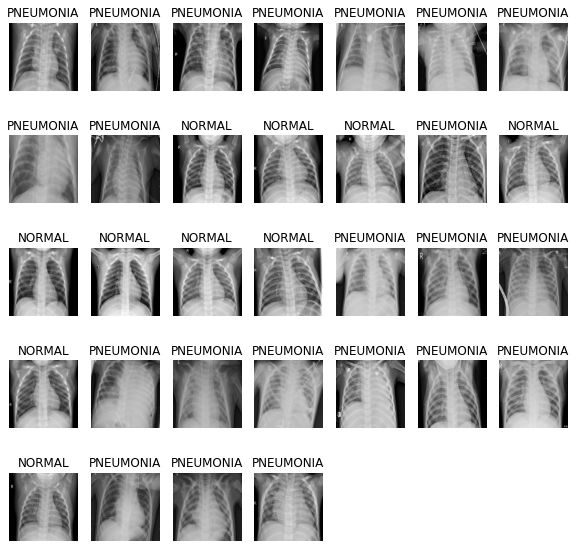

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

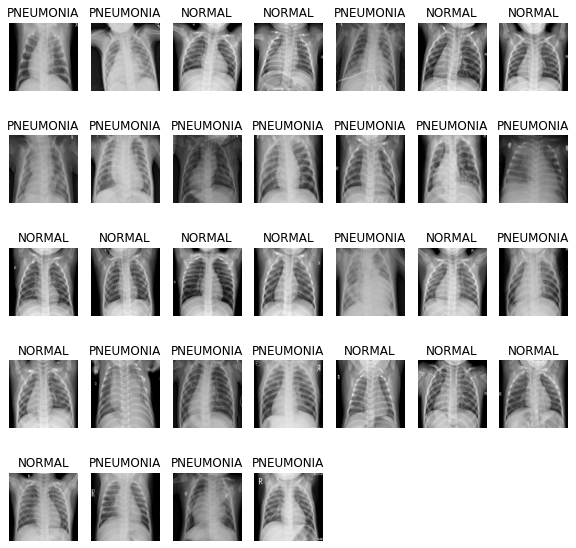

In [17]:
image_batch2, label_batch2 = next(iter(train_ds2))
show_batch(image_batch2.numpy(), label_batch2.numpy())

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [21]:
def build_model2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        #tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        #tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0),
        dense_block(128, 0),
        dense_block(64, 0),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [23]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=(TRAIN_IMG_COUNT // BATCH_SIZE) * 5,
    decay_rate=0.9,
    staircase=True)

In [24]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [25]:
with tf.device('/GPU:0'):#dropout 미사용
    model2 = build_model2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
with tf.device('/GPU:0'):#class_weight 미사용
    model3 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [27]:
with tf.device('/GPU:0'):#lr_schedule 사용
    model4 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model4.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),        
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [28]:
with tf.device('/GPU:0'):#augmentation  사용
    model5 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model5.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [29]:
with tf.device('/GPU:0'):#class_weight 미사용, lr_schedule, augmentation  사용
    model6 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model6.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [30]:
with tf.device('/GPU:0'):#dropout 미사용, augmentation  사용
    model7 = build_model2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model7.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [31]:
with tf.device('/GPU:0'):#lr_schedule, augmentation  사용
    model8 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model8.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [32]:
with tf.device('/GPU:0'):
    history1 = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/15
130/130 [==============================] - 88s 462ms/step - loss: 0.5236 - accuracy: 0.7310 - precision: 0.9204 - recall: 0.6978 - val_loss: 0.6164 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 57s 440ms/step - loss: 0.2026 - accuracy: 0.9255 - precision: 0.9793 - recall: 0.9197 - val_loss: 0.8544 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 60s 463ms/step - loss: 0.1542 - accuracy: 0.9474 - precision: 0.9849 - recall: 0.9438 - val_loss: 1.1405 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 59s 456ms/step - loss: 0.1438 - accuracy: 0.9524 - precision: 0.9844 - recall: 0.9510 - val_loss: 1.6376 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 60s 465ms/step - loss: 0.1267 - accura

In [33]:
with tf.device('/GPU:0'):#dropout 미사용
    history2 = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/15
130/130 [==============================] - 70s 454ms/step - loss: 0.2670 - accuracy: 0.8785 - precision: 0.9671 - recall: 0.8641 - val_loss: 0.6161 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 58s 447ms/step - loss: 0.1070 - accuracy: 0.9650 - precision: 0.9889 - recall: 0.9638 - val_loss: 0.8817 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 58s 450ms/step - loss: 0.1053 - accuracy: 0.9679 - precision: 0.9856 - recall: 0.9705 - val_loss: 1.1521 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 60s 466ms/step - loss: 0.0841 - accuracy: 0.9694 - precision: 0.9878 - recall: 0.9713 - val_loss: 1.1706 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 61s 474ms/step - loss: 0.0723 - accura

In [34]:
with tf.device('/GPU:0'):#class_weight 미사용
    history3 = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    )

Epoch 1/15
130/130 [==============================] - 70s 450ms/step - loss: 0.6034 - accuracy: 0.7159 - precision: 0.8927 - recall: 0.7039 - val_loss: 0.6537 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 58s 447ms/step - loss: 0.2021 - accuracy: 0.9303 - precision: 0.9662 - recall: 0.9395 - val_loss: 0.9750 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 58s 450ms/step - loss: 0.1517 - accuracy: 0.9475 - precision: 0.9634 - recall: 0.9656 - val_loss: 1.1708 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 59s 457ms/step - loss: 0.1503 - accuracy: 0.9464 - precision: 0.9612 - recall: 0.9674 - val_loss: 1.6720 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 61s 473ms/step - loss: 0.1188 - accura

In [35]:
with tf.device('/GPU:0'):#lr_schedule 사용
    history4 = model4.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/15
130/130 [==============================] - 70s 454ms/step - loss: 0.5253 - accuracy: 0.7411 - precision: 0.9009 - recall: 0.7298 - val_loss: 2.6104 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 58s 451ms/step - loss: 0.2386 - accuracy: 0.9006 - precision: 0.9704 - recall: 0.8940 - val_loss: 1.0333 - val_accuracy: 0.6309 - val_precision: 1.0000 - val_recall: 0.4967
Epoch 3/15
130/130 [==============================] - 59s 454ms/step - loss: 0.1898 - accuracy: 0.9269 - precision: 0.9739 - recall: 0.9268 - val_loss: 0.6048 - val_accuracy: 0.8145 - val_precision: 0.8235 - val_recall: 0.9507
Epoch 4/15
130/130 [==============================] - 59s 458ms/step - loss: 0.1660 - accuracy: 0.9385 - precision: 0.9811 - recall: 0.9349 - val_loss: 0.1172 - val_accuracy: 0.9561 - val_precision: 0.9573 - val_recall: 0.9840
Epoch 5/15
130/130 [==============================] - 61s 472ms/step - loss: 0.1458 - accura

In [36]:
with tf.device('/GPU:0'):#augmentation  사용
    history5 = model5.fit(
        train_ds2,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds2,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/15
130/130 [==============================] - 70s 452ms/step - loss: 0.5544 - accuracy: 0.7192 - precision: 0.9187 - recall: 0.6873 - val_loss: 0.5814 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 58s 450ms/step - loss: 0.2214 - accuracy: 0.9229 - precision: 0.9754 - recall: 0.9191 - val_loss: 0.7329 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 59s 456ms/step - loss: 0.1637 - accuracy: 0.9446 - precision: 0.9818 - recall: 0.9434 - val_loss: 1.0561 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 60s 462ms/step - loss: 0.1475 - accuracy: 0.9484 - precision: 0.9845 - recall: 0.9460 - val_loss: 1.5756 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 62s 476ms/step - loss: 0.1585 - accura

In [37]:
with tf.device('/GPU:0'):#class_weight 미사용, lr_schedule, augmentation  사용
    history6 = model6.fit(
        train_ds2,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds2,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    )

Epoch 1/15
130/130 [==============================] - 71s 460ms/step - loss: 0.5575 - accuracy: 0.7521 - precision: 0.8391 - recall: 0.8230 - val_loss: 0.5751 - val_accuracy: 0.7412 - val_precision: 0.7410 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 60s 461ms/step - loss: 0.2375 - accuracy: 0.9071 - precision: 0.9366 - recall: 0.9403 - val_loss: 0.1860 - val_accuracy: 0.9326 - val_precision: 0.9803 - val_recall: 0.9267
Epoch 3/15
130/130 [==============================] - 59s 460ms/step - loss: 0.1754 - accuracy: 0.9335 - precision: 0.9584 - recall: 0.9527 - val_loss: 0.1786 - val_accuracy: 0.9473 - val_precision: 0.9478 - val_recall: 0.9828
Epoch 4/15
130/130 [==============================] - 61s 470ms/step - loss: 0.1671 - accuracy: 0.9413 - precision: 0.9641 - recall: 0.9575 - val_loss: 0.5411 - val_accuracy: 0.8438 - val_precision: 0.8253 - val_recall: 0.9987
Epoch 5/15
130/130 [==============================] - 63s 488ms/step - loss: 0.1275 - accura

In [38]:
with tf.device('/GPU:0'):#dropout 미사용, augmentation  사용
    history7 = model7.fit(
        train_ds2,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds2,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/15
130/130 [==============================] - 71s 460ms/step - loss: 0.2772 - accuracy: 0.8759 - precision: 0.9702 - recall: 0.8592 - val_loss: 0.5842 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 59s 454ms/step - loss: 0.1321 - accuracy: 0.9513 - precision: 0.9850 - recall: 0.9497 - val_loss: 0.6128 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 58s 451ms/step - loss: 0.0949 - accuracy: 0.9647 - precision: 0.9912 - recall: 0.9613 - val_loss: 0.7933 - val_accuracy: 0.7393 - val_precision: 0.7393 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 61s 471ms/step - loss: 0.0901 - accuracy: 0.9680 - precision: 0.9897 - recall: 0.9668 - val_loss: 1.7323 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 62s 479ms/step - loss: 0.0998 - accura

In [39]:
with tf.device('/GPU:0'):#lr_schedule, augmentation  사용
    history8 = model8.fit(
        train_ds2,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds2,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/15
130/130 [==============================] - 70s 454ms/step - loss: 0.6561 - accuracy: 0.6881 - precision: 0.8771 - recall: 0.6748 - val_loss: 1.3689 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 58s 447ms/step - loss: 0.2155 - accuracy: 0.9262 - precision: 0.9762 - recall: 0.9227 - val_loss: 0.5378 - val_accuracy: 0.7842 - val_precision: 0.7726 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 59s 453ms/step - loss: 0.1934 - accuracy: 0.9313 - precision: 0.9809 - recall: 0.9266 - val_loss: 0.3069 - val_accuracy: 0.8848 - val_precision: 0.9969 - val_recall: 0.8459
Epoch 4/15
130/130 [==============================] - 59s 459ms/step - loss: 0.1693 - accuracy: 0.9329 - precision: 0.9825 - recall: 0.9265 - val_loss: 3.7175 - val_accuracy: 0.3486 - val_precision: 1.0000 - val_recall: 0.1154
Epoch 5/15
130/130 [==============================] - 62s 478ms/step - loss: 0.1783 - accura

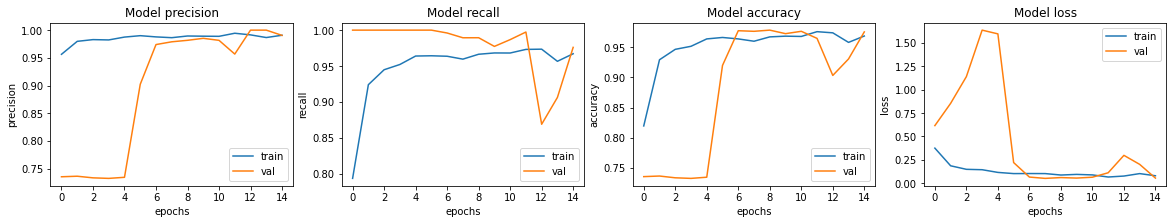

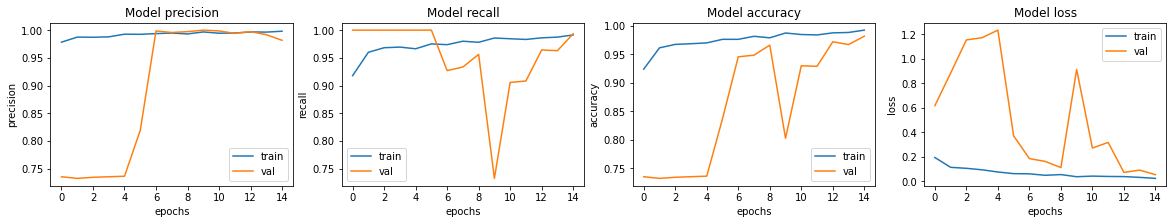

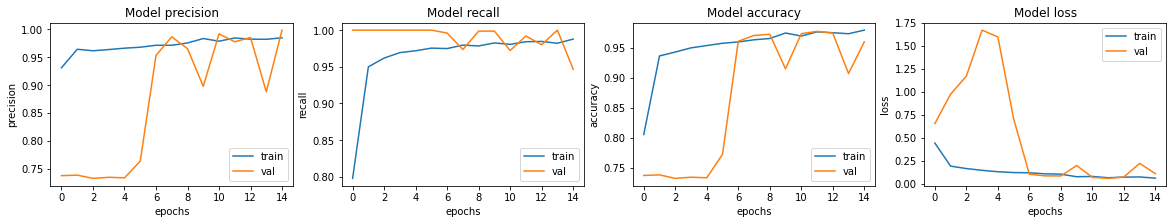

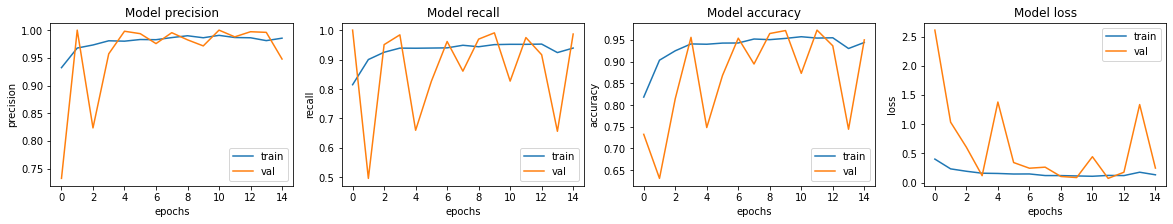

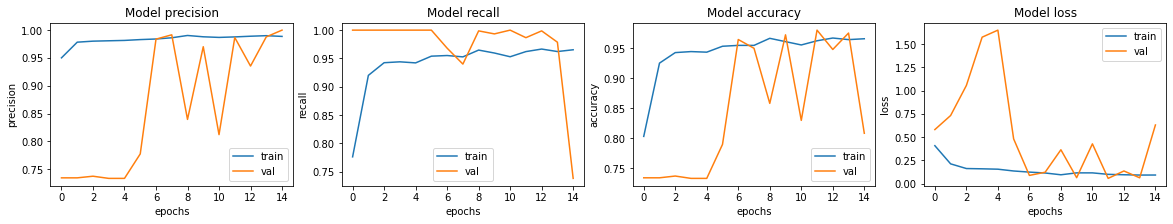

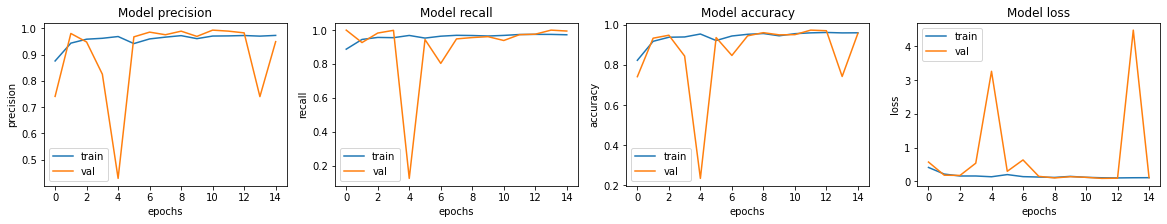

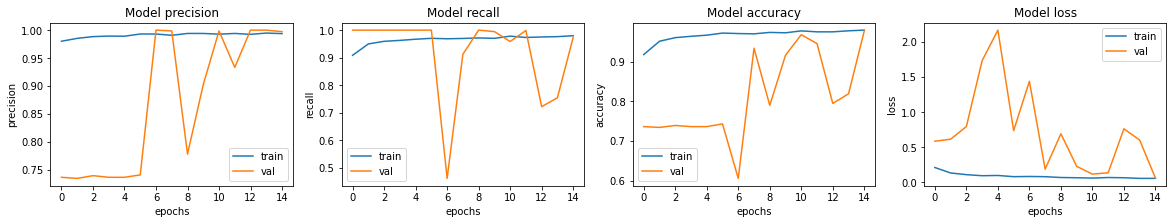

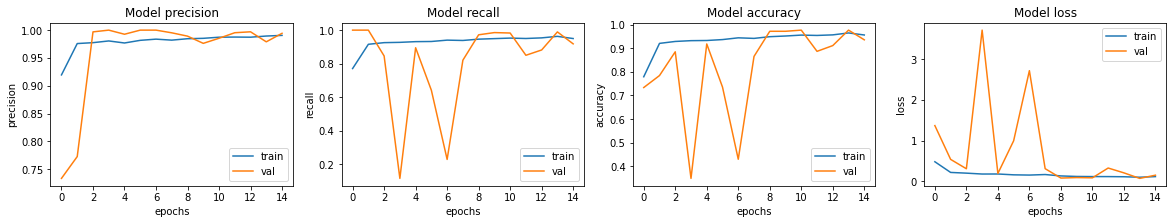

In [40]:
for hi in [history1,history2,history3,history4,history5,history6,history7,history8]:
    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(hi.history[met])
        ax[i].plot(hi.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

In [41]:
for i in [model,model2,model3,model4,model5,model6,model7,model8]:
    loss, accuracy, precision, recall = i.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')
    print('')

20/20 [==============================] - 35s 2s/step - loss: 0.7416 - accuracy: 0.8349 - precision: 0.7959 - recall: 0.9897
Loss: 0.7415652871131897,
Accuracy: 0.8349359035491943,
Precision: 0.7958762645721436,
Recall: 0.9897435903549194

20/20 [==============================] - 6s 275ms/step - loss: 1.3847 - accuracy: 0.7388 - precision: 0.7060 - recall: 0.9974
Loss: 1.3846588134765625,
Accuracy: 0.7387820482254028,
Precision: 0.7059891223907471,
Recall: 0.9974358677864075

20/20 [==============================] - 6s 286ms/step - loss: 0.5171 - accuracy: 0.8381 - precision: 0.8094 - recall: 0.9692
Loss: 0.5170624256134033,
Accuracy: 0.8381410241127014,
Precision: 0.8094218373298645,
Recall: 0.9692307710647583

20/20 [==============================] - 6s 283ms/step - loss: 1.2658 - accuracy: 0.7500 - precision: 0.7151 - recall: 0.9974
Loss: 1.2658432722091675,
Accuracy: 0.75,
Precision: 0.7150735259056091,
Recall: 0.9974358677864075

20/20 [==============================] - 6s 287ms/st

BATCH_SIZE = 16
EPOCHS = 10
lr_schedule initial_learning_rate = 0.1

39/39 [==============================] - 6s 148ms/step - loss: 1.0825 - accuracy: 0.7340 - precision: 0.7022 - recall: 0.9974
Loss: 1.0824826955795288,
Accuracy: 0.7339743375778198,
Precision: 0.7021660804748535,
Recall: 0.9974358677864075

39/39 [==============================] - 6s 147ms/step - loss: 2.3532 - accuracy: 0.6667 - precision: 0.6522 - recall: 1.0000
Loss: 2.353188991546631,
Accuracy: 0.6666666865348816,
Precision: 0.6521739363670349,
Recall: 1.0

39/39 [==============================] - 6s 142ms/step - loss: 0.3658 - accuracy: 0.8766 - precision: 0.8565 - recall: 0.9641
Loss: 0.3657520115375519,
Accuracy: 0.8766025900840759,
Precision: 0.8564920425415039,
Recall: 0.964102566242218

39/39 [==============================] - 6s 146ms/step - loss: 0.3841 - accuracy: 0.8237 - precision: 0.7881 - recall: 0.9821
Loss: 0.3840732276439667,
Accuracy: 0.8237179517745972,
Precision: 0.7880658507347107,
Recall: 0.9820512533187866

39/39 [==============================] - 6s 146ms/step - loss: 0.5071 - accuracy: 0.8109 - precision: 0.7833 - recall: 0.9641
Loss: 0.5070774555206299,
Accuracy: 0.8108974099159241,
Precision: 0.7833333611488342,
Recall: 0.964102566242218

BATCH_SIZE = 16
EPOCHS = 15
lr_schedule initial_learning_rate = 0.1

39/39 [==============================] - 6s 140ms/step - loss: 0.8405 - accuracy: 0.7933 - precision: 0.7524 - recall: 0.9974
Loss: 0.8404517769813538,
Accuracy: 0.7932692170143127,
Precision: 0.752417802810669,
Recall: 0.9974358677864075

39/39 [==============================] - 6s 146ms/step - loss: 0.5816 - accuracy: 0.8670 - precision: 0.8359 - recall: 0.9795
Loss: 0.5815514922142029,
Accuracy: 0.8669871687889099,
Precision: 0.8358862400054932,
Recall: 0.9794871807098389

39/39 [==============================] - 6s 146ms/step - loss: 1.1065 - accuracy: 0.7196 - precision: 0.6903 - recall: 1.0000
Loss: 1.1064836978912354,
Accuracy: 0.7195512652397156,
Precision: 0.6902654767036438,
Recall: 1.0

39/39 [==============================] - 6s 148ms/step - loss: 862.4270 - accuracy: 0.6346 - precision: 0.6528 - recall: 0.8872
Loss: 862.427001953125,
Accuracy: 0.6346153616905212,
Precision: 0.652830183506012,
Recall: 0.8871794939041138

39/39 [==============================] - 6s 145ms/step - loss: 0.3466 - accuracy: 0.8782 - precision: 0.9198 - recall: 0.8821
Loss: 0.3466353714466095,
Accuracy: 0.8782051205635071,
Precision: 0.9197860956192017,
Recall: 0.8820512890815735

BATCH_SIZE = 32
EPOCHS = 10
lr_schedule initial_learning_rate = 0.01

20/20 [==============================] - 29s 2s/step - loss: 0.4435 - accuracy: 0.8654 - precision: 0.8608 - recall: 0.9359
Loss: 0.4434603750705719,
Accuracy: 0.8653846383094788,
Precision: 0.8608490824699402,
Recall: 0.9358974099159241

20/20 [==============================] - 6s 279ms/step - loss: 0.7887 - accuracy: 0.8205 - precision: 0.7837 - recall: 0.9846
Loss: 0.7886894941329956,
Accuracy: 0.8205128312110901,
Precision: 0.7836734652519226,
Recall: 0.9846153855323792

20/20 [==============================] - 6s 276ms/step - loss: 0.4675 - accuracy: 0.8301 - precision: 0.8184 - recall: 0.9359
Loss: 0.4675428867340088,
Accuracy: 0.8301281929016113,
Precision: 0.818385660648346,
Recall: 0.9358974099159241

20/20 [==============================] - 6s 279ms/step - loss: 0.5520 - accuracy: 0.8173 - precision: 0.7828 - recall: 0.9795
Loss: 0.5520219206809998,
Accuracy: 0.817307710647583,
Precision: 0.7827869057655334,
Recall: 0.9794871807098389

20/20 [==============================] - 6s 274ms/step - loss: 0.4533 - accuracy: 0.8397 - precision: 0.8098 - recall: 0.9718
Loss: 0.4532686471939087,
Accuracy: 0.8397436141967773,
Precision: 0.80982905626297,
Recall: 0.971794843673706

BATCH_SIZE = 32
EPOCHS = 10
lr_schedule initial_learning_rate = 0.01

20/20 [==============================] - 28s 1s/step - loss: 0.4922 - accuracy: 0.8349 - precision: 0.8196 - recall: 0.9436
Loss: 0.49215540289878845,
Accuracy: 0.8349359035491943,
Precision: 0.8195990920066833,
Recall: 0.9435897469520569

20/20 [==============================] - 6s 281ms/step - loss: 1.7320 - accuracy: 0.7083 - precision: 0.6818 - recall: 1.0000
Loss: 1.7320138216018677,
Accuracy: 0.7083333134651184,
Precision: 0.6818181872367859,
Recall: 1.0

20/20 [==============================] - 6s 275ms/step - loss: 0.7153 - accuracy: 0.8141 - precision: 0.7762 - recall: 0.9872
Loss: 0.7153419256210327,
Accuracy: 0.8141025900840759,
Precision: 0.7762096524238586,
Recall: 0.9871794581413269

20/20 [==============================] - 6s 266ms/step - loss: 0.5108 - accuracy: 0.8542 - precision: 0.8345 - recall: 0.9564
Loss: 0.5107851028442383,
Accuracy: 0.8541666865348816,
Precision: 0.8344519138336182,
Recall: 0.9564102292060852

20/20 [==============================] - 6s 270ms/step - loss: 0.4829 - accuracy: 0.8205 - precision: 0.8022 - recall: 0.9462
Loss: 0.482866495847702,
Accuracy: 0.8205128312110901,
Precision: 0.802173912525177,
Recall: 0.9461538195610046

BATCH_SIZE = 8
EPOCHS = 10
lr_schedule initial_learning_rate = 0.01

78/78 [==============================] - 6s 73ms/step - loss: 0.5702 - accuracy: 0.7949 - precision: 0.7559 - recall: 0.9923
Loss: 0.5701884627342224,
Accuracy: 0.7948718070983887,
Precision: 0.755859375,
Recall: 0.9923076629638672

78/78 [==============================] - 6s 75ms/step - loss: 1.3676 - accuracy: 0.7612 - precision: 0.7269 - recall: 0.9897
Loss: 1.3676329851150513,
Accuracy: 0.7612179517745972,
Precision: 0.7269303202629089,
Recall: 0.9897435903549194

78/78 [==============================] - 6s 76ms/step - loss: 0.6915 - accuracy: 0.7660 - precision: 0.7293 - recall: 0.9949
Loss: 0.6915494203567505,
Accuracy: 0.7660256624221802,
Precision: 0.7293233275413513,
Recall: 0.9948717951774597

78/78 [==============================] - 6s 76ms/step - loss: 3.1055 - accuracy: 0.3734 - precision: 0.4000 - recall: 0.0051
Loss: 3.105530261993408,
Accuracy: 0.37339743971824646,
Precision: 0.4000000059604645,
Recall: 0.0051282052882015705

78/78 [==============================] - 6s 75ms/step - loss: 0.4536 - accuracy: 0.8253 - precision: 0.8353 - recall: 0.8974
Loss: 0.4535781741142273,
Accuracy: 0.8253205418586731,
Precision: 0.8353222012519836,
Recall: 0.8974359035491943

BATCH_SIZE = 16
EPOCHS = 15
lr_schedule initial_learning_rate = 0.001

39/39 [==============================] - 6s 140ms/step - loss: 0.4655 - accuracy: 0.8606 - precision: 0.8272 - recall: 0.9821
Loss: 0.4654700458049774,
Accuracy: 0.8605769276618958,
Precision: 0.8272138237953186,
Recall: 0.9820512533187866

39/39 [==============================] - 6s 146ms/step - loss: 1.2104 - accuracy: 0.7901 - precision: 0.7554 - recall: 0.9821
Loss: 1.210377812385559,
Accuracy: 0.7900640964508057,
Precision: 0.7554240822792053,
Recall: 0.9820512533187866

39/39 [==============================] - 6s 143ms/step - loss: 1.1959 - accuracy: 0.7228 - precision: 0.6927 - recall: 1.0000
Loss: 1.1958869695663452,
Accuracy: 0.7227563858032227,
Precision: 0.6927176117897034,
Recall: 1.0

39/39 [==============================] - 6s 145ms/step - loss: 0.8181 - accuracy: 0.8093 - precision: 0.7782 - recall: 0.9718
Loss: 0.8180930614471436,
Accuracy: 0.8092948794364929,
Precision: 0.77823406457901,
Recall: 0.971794843673706

39/39 [==============================] - 6s 144ms/step - loss: 0.6130 - accuracy: 0.8301 - precision: 0.7971 - recall: 0.9769
Loss: 0.6130178570747375,
Accuracy: 0.8301281929016113,
Precision: 0.7970711588859558,
Recall: 0.9769230484962463

BATCH_SIZE = 16
EPOCHS = 20
lr_schedule initial_learning_rate = 0.1

39/39 [==============================] - 7s 176ms/step - loss: 1.6586 - accuracy: 0.6538 - precision: 0.6436 - recall: 1.0000
Loss: 1.6585592031478882,
Accuracy: 0.6538461446762085,
Precision: 0.6435643434524536,
Recall: 1.0

39/39 [==============================] - 6s 144ms/step - loss: 1.1482 - accuracy: 0.7917 - precision: 0.7621 - recall: 0.9692
Loss: 1.1482197046279907,
Accuracy: 0.7916666865348816,
Precision: 0.7620967626571655,
Recall: 0.9692307710647583

39/39 [==============================] - 6s 143ms/step - loss: 1.1802 - accuracy: 0.7244 - precision: 0.6946 - recall: 0.9974
Loss: 1.180216908454895,
Accuracy: 0.7243589758872986,
Precision: 0.6946428418159485,
Recall: 0.9974358677864075

39/39 [==============================] - 6s 145ms/step - loss: 32.0314 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 32.03135299682617,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0

39/39 [==============================] - 6s 146ms/step - loss: 0.9339 - accuracy: 0.7564 - precision: 0.7212 - recall: 0.9949
Loss: 0.9338839650154114,
Accuracy: 0.7564102411270142,
Precision: 0.7211896181106567,
Recall: 0.9948717951774597

20/20 [==============================] - 35s 2s/step - loss: 0.7416 - accuracy: 0.8349 - precision: 0.7959 - recall: 0.9897
Loss: 0.7415652871131897,
Accuracy: 0.8349359035491943,
Precision: 0.7958762645721436,
Recall: 0.9897435903549194

20/20 [==============================] - 6s 275ms/step - loss: 1.3847 - accuracy: 0.7388 - precision: 0.7060 - recall: 0.9974
Loss: 1.3846588134765625,
Accuracy: 0.7387820482254028,
Precision: 0.7059891223907471,
Recall: 0.9974358677864075

20/20 [==============================] - 6s 286ms/step - loss: 0.5171 - accuracy: 0.8381 - precision: 0.8094 - recall: 0.9692
Loss: 0.5170624256134033,
Accuracy: 0.8381410241127014,
Precision: 0.8094218373298645,
Recall: 0.9692307710647583

20/20 [==============================] - 6s 283ms/step - loss: 1.2658 - accuracy: 0.7500 - precision: 0.7151 - recall: 0.9974
Loss: 1.2658432722091675,
Accuracy: 0.75,
Precision: 0.7150735259056091,
Recall: 0.9974358677864075

20/20 [==============================] - 6s 287ms/step - loss: 0.3851 - accuracy: 0.8814 - precision: 0.9051 - recall: 0.9051
Loss: 0.3850751519203186,
Accuracy: 0.8814102411270142,
Precision: 0.9051281809806824,
Recall: 0.9051281809806824

20/20 [==============================] - 6s 268ms/step - loss: 1.2772 - accuracy: 0.7212 - precision: 0.6922 - recall: 0.9974
Loss: 1.277222752571106,
Accuracy: 0.7211538553237915,
Precision: 0.6921707987785339,
Recall: 0.9974358677864075

20/20 [==============================] - 6s 280ms/step - loss: 0.5420 - accuracy: 0.8606 - precision: 0.8230 - recall: 0.9897
Loss: 0.5420075058937073,
Accuracy: 0.8605769276618958,
Precision: 0.8230277299880981,
Recall: 0.9897435903549194

20/20 [==============================] - 6s 270ms/step - loss: 0.5644 - accuracy: 0.8478 - precision: 0.8228 - recall: 0.9641
Loss: 0.5643609762191772,
Accuracy: 0.8477563858032227,
Precision: 0.8227571249008179,
Recall: 0.964102566242218

하이퍼 파라미터와 regularization, augmentation 등의 기법의 사용 여부를 바꿔보며 그에 따른 정확도를 확인해 보았다.
이미지를 작게 변환하여 이용하고, 데이터의 양이 많은편이 아니라서 결과값이 안정적이지 못하고 변동이 심한것 같다.
dropout, class_weight,augmentation 사용이 성능향상에 대체로 도움된다.
Learning Rate Decay의 경우 하이퍼파라미터 설정에 따라 큰 차이가 나타났다. 잘 설정해 준다면 정확도 향상에 도움이 될 것 같다.
class_weight 미사용, lr_schedule, augmentation  사용 / dropout 미사용, augmentation  사용 / lr_schedule, augmentation  사용 3가지를 추가로 해 보았는데 기본 모델에 augmentation 사용 여부만 추가한 모델이 정확도가 가장 높게 나왔다. 결과적으로 dropout, class_weight, augmentation 전부 사용한 경우가 가장 정확도가 높았다.